# Statistical Analysis and Reproducibility

## Objectives
- Understand the main metrics characterizing the brain morphology
- Extract and rely on a set of metrics to assess the effect of age on multiple cortical regions
- Understand need for reproducibility

## Useful resources:
- FreeSurfer output [description](https://surfer.nmr.mgh.harvard.edu/fswiki/ReconAllTableStableV5.3)

## Dataset used:
- [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI [Collection](https://openneuro.org/datasets/ds002790/versions/2.0.0)

In [249]:
import os
import glob
import numpy as np
import pandas as pd
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

In [250]:
%matplotlib inline

## Quantifying tissue properties

### Get data

In [251]:
data_dir = '../data/AOMIC'
fs_stats_dir = '../data/AOMIC/derivatives/fs_stats'

### Metric from volumetric data: region volumes

In [252]:
t1_file = data_dir + '/sub-0001/anat/sub-0001_T1w.nii.gz'
t1 = nib.load(t1_file)

Let's measure the volume of the right caudate region of our subject, from the subcortical segmentation obtained from Freesurfer.

In [253]:
t1_aseg_file = data_dir + '/derivatives/freesurfer/sub-0001/mri/aseg.mgz'
t1_aseg = nib.load(t1_aseg_file)

According to the [Freesurfer look-up table](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT), the ROI of interest has intensity 50.

In [254]:
roi_ix = 50
roi_mask_arr_bool = (t1_aseg.get_fdata() == roi_ix)
roi_mask_arr = roi_mask_arr_bool.astype(int)
roi_mask = nib.Nifti1Image(roi_mask_arr, affine=t1_aseg.affine)

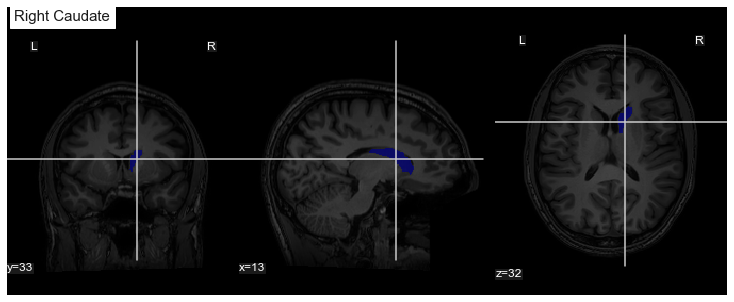

In [255]:
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask, bg_img=t1, alpha=0.7, title='Right Caudate', figure=fig);

We can get the number of voxels by counting them in the mask:

In [256]:
caudate_R_n_vox = roi_mask_arr.sum()
caudate_R_n_vox

3858

However we have to take into account voxel sizes in standard unit:

In [257]:
voxel_dimensions = t1.header.get_zooms()
voxel_dimensions

(1.0, 1.0, 1.0)

In [258]:
vox_size = np.array(voxel_dimensions).prod()
vox_size

1.0

The volume of interest in mm3 is then:

In [259]:
caudate_R_vol_mm3 = caudate_R_n_vox * vox_size
caudate_R_vol_mm3

3858.0

Volume metrics are available for a collection of ROIs in the `aseg.stats` file of the Freesurfer `stats` output directory.

In [260]:
fs_rawstats_dir = data_dir + "/derivatives/freesurfer/sub-0001/stats"

In [261]:
with open(os.path.join(fs_rawstats_dir, "aseg.stats")) as fs_stats_file:
    lines = fs_stats_file.readlines()

In [262]:
lines

['# Title Segmentation Statistics \n',
 '# \n',
 '# generating_program mri_segstats\n',
 '# cvs_version $Id: mri_segstats.c,v 1.121 2016/05/31 17:27:11 greve Exp $\n',
 '# cmdline mri_segstats --seg mri/aseg.mgz --sum stats/aseg.stats --pv mri/norm.mgz --empty --brainmask mri/brainmask.mgz --brain-vol-from-seg --excludeid 0 --excl-ctxgmwm --supratent --subcortgray --in mri/norm.mgz --in-intensity-name norm --in-intensity-units MR --etiv --surf-wm-vol --surf-ctx-vol --totalgray --euler --ctab /opt/freesurfer/ASegStatsLUT.txt --subject sub-0001 \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# anatomy_type volume\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# subjectname sub-0001\n',
 '# Measure BrainSeg, BrainSegVol, Brain Segmentation Volume, 1248820.000000, mm^3\n',
 '# Measure BrainSegNotVent, BrainSegVolNotVent, Brain Segmentation Volume Without Ventricles, 1235952.000000, mm^3\n',
 '# Measure BrainSegNotVentSurf, Brai

There's lots of information in this file, can you return the only the lines we are interested about?

*Hint* from the # ColHeaders line and below


Solution

In [263]:
lines[79:]

['# ColHeaders  Index SegId NVoxels Volume_mm3 StructName normMean normStdDev normMin normMax normRange  \n',
 '  1   4      3820     4245.9  Left-Lateral-Ventricle            30.4424    13.2599     7.0000    83.0000    76.0000 \n',
 '  2   5        90      121.8  Left-Inf-Lat-Vent                 52.6000     8.3462    31.0000    70.0000    39.0000 \n',
 '  3   7     15218    15921.7  Left-Cerebellum-White-Matter      83.0076     6.6311    29.0000    96.0000    67.0000 \n',
 '  4   8     62023    62396.5  Left-Cerebellum-Cortex            57.3846     9.3904    11.0000    89.0000    78.0000 \n',
 '  5  10      7702     7311.5  Left-Thalamus-Proper              84.7959    10.4186    25.0000   106.0000    81.0000 \n',
 '  6  11      3621     3510.6  Left-Caudate                      72.8685     8.0645    41.0000    99.0000    58.0000 \n',
 '  7  12      5601     5527.1  Left-Putamen                      81.1578     7.0877    51.0000   105.0000    54.0000 \n',
 '  8  13      2057     1995.

Let just look at the Right Caudate we calculated by hand before.

The first four columns are: Index SegId NVoxels Volume_mm3 StructName

In [264]:
# This filters the list and returns elements that contain 'Right-Caudate'
[x for x in lines if 'Right-Caudate' in x]

[' 24  50      3858     3804.7  Right-Caudate                     73.2118     7.9099    37.0000    96.0000    59.0000 \n']

The number of voxels are the same as what we calculated: `3858`
But the volume is slightly different: `3804.7`

The difference in volume is probably from the fact that Freesurfer takes into account the proportion of GM in each voxel. This can be done "geometrically" by looking at the fraction of the voxel inside the GM surface, or by interpreting the probability of GM presence as the GM partial volume. Let's check what we get with the latter.

This differs from the FreeSurfer output because it isn't the 'geometric' calculation of the caudate volume. However it does give us a better idea of the true volume, as some voxels may include a mix of GM and WM!

### Metric from surface data with Freesurfer: cortical thickness

Freesurfer output by default several files to quantify both volume and surface data of each subject. After processing with smriprep/fmriprep, these files can be found in `derivatives/freesurfer/stats`.

In [265]:
os.listdir(fs_rawstats_dir)

['rh.BA_exvivo.stats',
 'rh.aparc.pial.stats',
 'lh.aparc.pial.stats',
 'rh.aparc.DKTatlas.stats',
 'lh.aparc.stats',
 'rh.aparc.a2009s.stats',
 'rh.aparc.stats',
 'lh.w-g.pct.stats',
 'lh.aparc.a2009s.stats',
 'lh.BA_exvivo.stats',
 'lh.curv.stats',
 'lh.BA_exvivo.thresh.stats',
 'rh.w-g.pct.stats',
 'rh.BA_exvivo.thresh.stats',
 'rh.curv.stats',
 'lh.aparc.DKTatlas.stats',
 'wmparc.stats',
 'aseg.stats']

`aseg` is for subcortical volumetric regions ("segmentation" in Freesurfer-speak) and `aparc` for cortical surface regions ("parcellation" in Freesurfer-speak). `aparc.stats` is for the Desikan-Killiany atlas while `aparc.a2009s.stats` is for the Destrieux atlas (more regions). 

#### Extracting cortical thickness information

Let's take a peek at the data output by Freesurfer before jumping to the clean group aggregated data 

In [266]:
# do this without islice module
n_lines = 75
with open(os.path.join(fs_rawstats_dir, "lh.aparc.a2009s.stats")) as fs_stats_file:
    lines = fs_stats_file.readlines()

In [267]:
lines[59:]

['# ColHeaders StructName NumVert SurfArea GrayVol ThickAvg ThickStd MeanCurv GausCurv FoldInd CurvInd\n',
 'G&S_frontomargin                         1116    840   1758  1.925 0.540     0.128     0.025       14     1.0\n',
 'G&S_occipital_inf                        1980   1336   3775  2.517 0.517     0.144     0.028       27     2.1\n',
 'G&S_paracentral                          1784   1108   2952  2.266 0.581     0.105     0.018       17     1.3\n',
 'G&S_subcentral                           1685   1170   3505  2.636 0.471     0.130     0.021       20     1.5\n',
 'G&S_transv_frontopol                     1028    754   2630  2.600 0.592     0.169     0.043       24     1.9\n',
 'G&S_cingul-Ant                           1811   1319   4075  2.777 0.676     0.126     0.031       25     2.2\n',
 'G&S_cingul-Mid-Ant                       1084    800   2121  2.606 0.443     0.127     0.022        9     1.1\n',
 'G&S_cingul-Mid-Post                      1180    858   2401  2.736 0.674     0.

The value of the cortical thickness at each vertex of the mesh (before averaging in each ROI) is also made available by freesurfer.

#### Plotting cortical thickness values on a subject meshes

Plotting the cortical thickness for the left hemisphere is then obtained by adding the overlay of thickness measures to our surface mesh we saw in episode 4. 

In [268]:
fs_surf_dir = "../data/AOMIC/derivatives/freesurfer/sub-0001/surf"
lh_sulcus = os.path.join(fs_surf_dir, "lh.sulc")
lh_pial = os.path.join(fs_surf_dir, "lh.pial")
lh_thickness = os.path.join(fs_surf_dir, "lh.thickness")

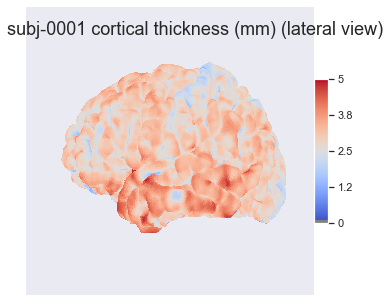

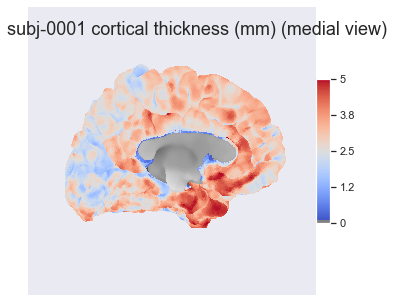

In [269]:
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='lateral', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (mm) (lateral view)');
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='medial', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (mm) (medial view)');

## Statistical Analysis

FreeSurfer provides outputs from the segmentation and parcellation using the approach above. These need to be cleaned up before we can analyse them in python using a package like `pandas`.

We will look at data that has already been cleaned for you, but please refer to the 06-Statistical_Analysis episode in the [sMRI Software Carpentry](https://carpentries-incubator.github.io/SDC-BIDS-sMRI/06-Statistical_Analysis/index.html) course for details on how to do this. 

Let's read in the cleaned dataframe below

In [270]:
fs_df = pd.read_csv(os.path.join(fs_stats_dir, 
                                 'data-cortical_type-aparc.a2009s_measure-thickness_merged_cleaned.csv'))

In [271]:
fs_df

,participant_id,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,G_and_S_cingul_Mid_Post,G_cingul_Post_dorsal,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952,1.560839e+06,lh
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970,1.115228e+06,lh
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765,1.186697e+06,lh
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916,9.527770e+05,lh
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881,1.497743e+06,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,sub-0222,2.459,2.203,2.045,2.814,2.614,2.824,2.706,2.503,3.067,...,2.308,2.470,2.129,2.286,2.264,3.006,2.41152,1024683,1.187630e+06,rh
448,sub-0223,2.212,2.365,2.214,2.515,2.326,2.957,2.786,2.734,2.966,...,2.559,2.746,2.738,2.619,2.432,2.683,2.48224,1080928,1.210314e+06,rh
449,sub-0224,2.076,2.653,2.098,2.307,2.463,2.735,2.602,2.686,3.169,...,2.136,3.253,2.495,2.309,2.562,2.418,2.41761,1140289,1.302062e+06,rh
450,sub-0225,3.061,2.164,2.097,2.462,2.753,3.134,2.786,2.604,3.072,...,2.174,3.429,2.385,2.378,2.303,2.105,2.41200,1080245,1.395822e+06,rh


#### Plotting distribution of cortical thickness among all subjects

We want to see how regional cortical thickness varies across these participants.

Let's take a look at the columns in the dataframe.

In [272]:
list(fs_df.columns)

['participant_id',
 'G_and_S_frontomargin',
 'G_and_S_occipital_inf',
 'G_and_S_paracentral',
 'G_and_S_subcentral',
 'G_and_S_transv_frontopol',
 'G_and_S_cingul_Ant',
 'G_and_S_cingul_Mid_Ant',
 'G_and_S_cingul_Mid_Post',
 'G_cingul_Post_dorsal',
 'G_cingul_Post_ventral',
 'G_cuneus',
 'G_front_inf_Opercular',
 'G_front_inf_Orbital',
 'G_front_inf_Triangul',
 'G_front_middle',
 'G_front_sup',
 'G_Ins_lg_and_S_cent_ins',
 'G_insular_short',
 'G_occipital_middle',
 'G_occipital_sup',
 'G_oc_temp_lat_fusifor',
 'G_oc_temp_med_Lingual',
 'G_oc_temp_med_Parahip',
 'G_orbital',
 'G_pariet_inf_Angular',
 'G_pariet_inf_Supramar',
 'G_parietal_sup',
 'G_postcentral',
 'G_precentral',
 'G_precuneus',
 'G_rectus',
 'G_subcallosal',
 'G_temp_sup_G_T_transv',
 'G_temp_sup_Lateral',
 'G_temp_sup_Plan_polar',
 'G_temp_sup_Plan_tempo',
 'G_temporal_inf',
 'G_temporal_middle',
 'Lat_Fis_ant_Horizont',
 'Lat_Fis_ant_Vertical',
 'Lat_Fis_post',
 'Pole_occipital',
 'Pole_temporal',
 'S_calcarine',
 'S_c

The `S_` and `G_` refer to sulcal and gyral. The cortex is highly folded and regions in the brain contain different patterns of this folding. A gyrus is the 'top' of the fold towards the edge of the brain, the sulcus is the 'bottom' of this fold towards the centre of the brain.

We just want to visualise the cortical thickness in the ROIs. Lets modify the dataframe to do this.

In [273]:
# 1st col is participant ID, last 4 cols are overall brain measures and the hemisphere label.
# lets get the columns inbetween for the ROIs
roi_cols = list(fs_df.columns[1:-4])

# now just select hemisphere indicator and ROI columns
plot_df = fs_df[['participant_id','hemi'] + roi_cols]

'Melting' is a way to reorganise a dataframe using pandas. Instead of many columns (1 for each ROI), we convert our dataframe to having many rows (1 for each ROI). This is otherwise known as going from 'wide' to 'long' format. 

Long data formats tend to be better for plotting and visualisation.

In [274]:
# Melt dataframe for easier visualization
plot_long_df = pd.melt(plot_df, id_vars = ['hemi'], 
                       value_vars = roi_cols, 
                       var_name ='ROI', 
                       value_name ='cortical thickness')

In [275]:
plot_long_df

,hemi,ROI,cortical thickness
0,lh,G_and_S_frontomargin,1.925
1,lh,G_and_S_frontomargin,2.405
2,lh,G_and_S_frontomargin,2.477
3,lh,G_and_S_frontomargin,2.179
4,lh,G_and_S_frontomargin,2.483
...,...,...,...
33443,rh,S_temporal_transverse,3.006
33444,rh,S_temporal_transverse,2.683
33445,rh,S_temporal_transverse,2.418
33446,rh,S_temporal_transverse,2.105


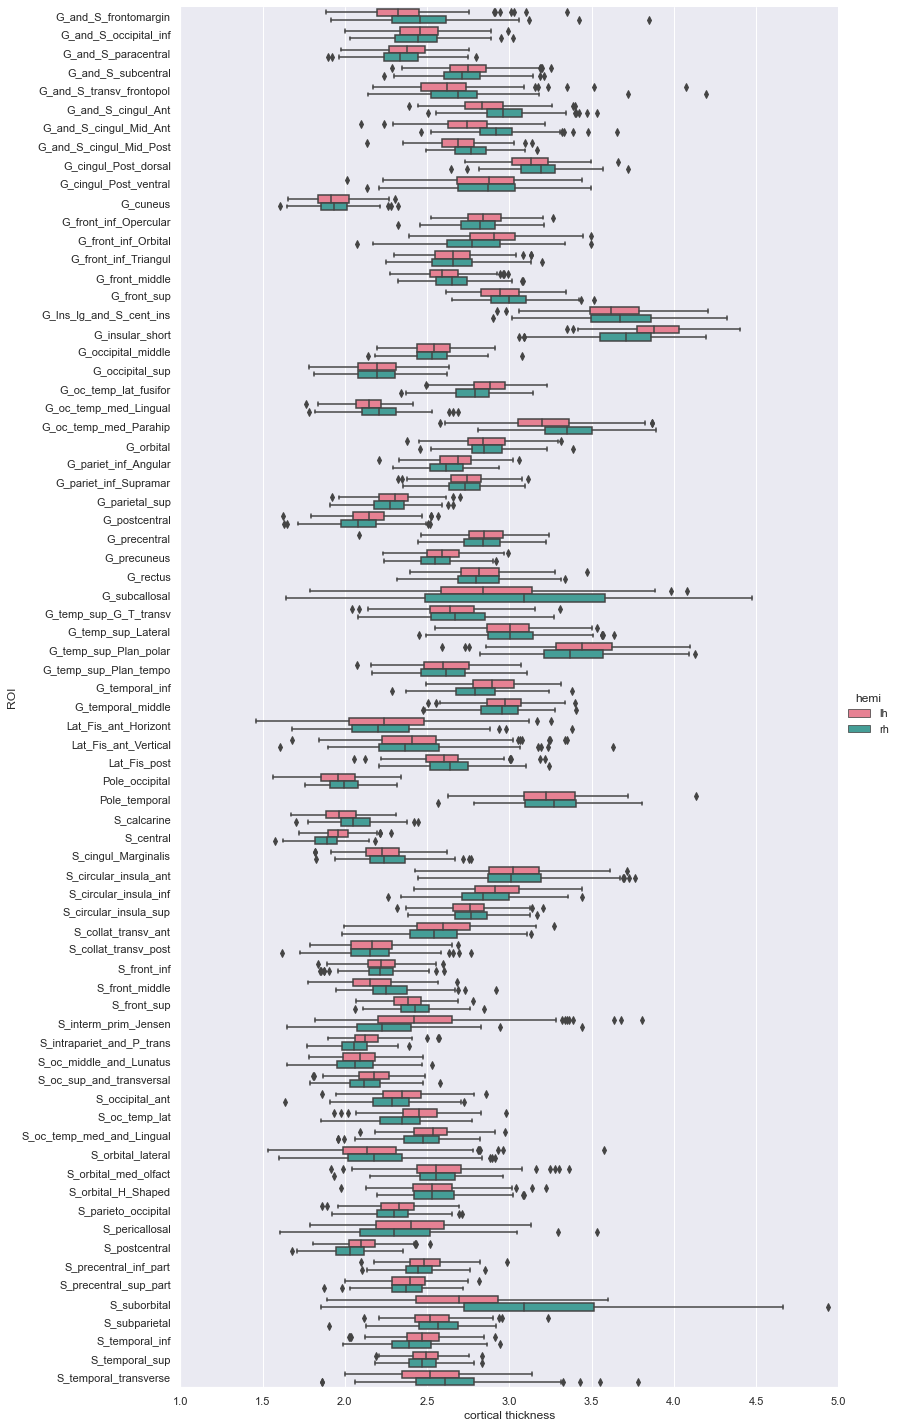

In [276]:
# plot the cortical thickness for all ROIs
sns.set(font_scale=1)
g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', aspect=0.6, 
                height=20, palette = sns.color_palette('husl',2), data=plot_long_df)
g.set(xlim=(1, 5));

## Statistical analysis: can we measure cortical thickness changes with age in young adults ?

### Creating our model predictors

#### Adding demographic data

In [277]:
subjects_info_withna = pd.read_table(os.path.join(data_dir, 'participants.tsv'))
subjects_info_withna

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


#### Data cleaning

##### Challenge: there may be an issue with the data. Can you spot it ?

Solution: NA values

##### Challenge: if you spotted the issue in the previous challenge, what would you propose to solve it ?

Solution

In [278]:
# drop the rows with NAs in
subjects_info = subjects_info_withna.dropna()

We now have two dataframes, one with the demographic data and one with our brain imaging data.

We can combine these two dataframes so the demographic and cortical thickness measures match up for each participant.

This is done using the `merge` command in pandas

In [279]:
# only keep demographic values of interest
demo_cols = ["participant_id", "age", "sex"]

# merge demographic and cortical thickness dataframes together
# rows with the same participant_id will be merged
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')

# take a look
fs_all_df

,participant_id,age,sex,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,25.50,M,1.925,2.517,2.266,2.636,2.600,2.777,2.606,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952,1560838.764,lh
1,sub-0001,25.50,M,2.216,2.408,2.381,2.698,2.530,2.947,2.896,...,2.324,2.273,2.588,2.548,2.465,2.675,2.51412,1235952,1560838.764,rh
2,sub-0002,23.25,F,2.405,2.340,2.400,2.849,2.724,2.888,2.658,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970,1115228.151,lh
3,sub-0002,23.25,F,2.682,2.454,2.511,2.725,2.874,3.202,3.012,...,2.429,2.664,2.676,2.220,2.291,2.714,2.48075,1056970,1115228.151,rh
4,sub-0003,25.00,F,2.477,2.041,2.255,2.648,2.616,2.855,2.924,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765,1186697.258,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,sub-0224,21.75,M,2.076,2.653,2.098,2.307,2.463,2.735,2.602,...,2.136,3.253,2.495,2.309,2.562,2.418,2.41761,1140289,1302062.101,rh
444,sub-0225,20.25,F,2.513,2.495,2.141,2.492,2.757,2.553,2.238,...,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245,1395821.902,lh
445,sub-0225,20.25,F,3.061,2.164,2.097,2.462,2.753,3.134,2.786,...,2.174,3.429,2.385,2.378,2.303,2.105,2.41200,1080245,1395821.902,rh
446,sub-0226,20.00,M,3.010,2.189,2.562,3.142,4.072,3.051,2.292,...,2.375,2.812,2.756,2.524,2.617,2.495,2.62877,1257771,1583713.483,lh


#### Looking at a single ROI: e.g. cingulate mid ant

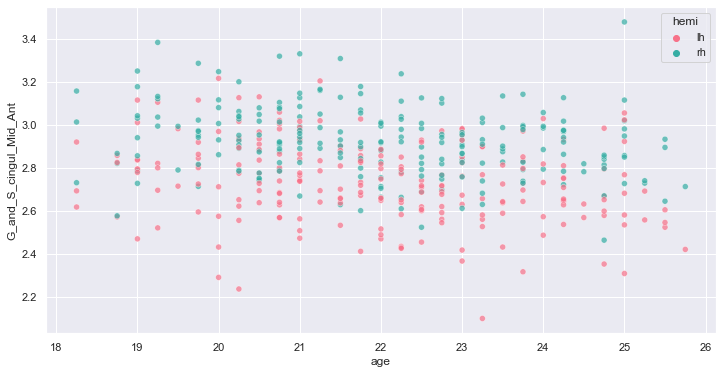

In [280]:
plt.figure(figsize=(12, 6))
g = sns.scatterplot(x='age', 
                    y='G_and_S_cingul_Mid_Ant', 
                    hue='hemi', 
                    alpha=0.7,
                    palette=sns.color_palette('husl',2), 
                    data=fs_all_df)

### Fitting a regression model

Visually there looks like a pattern of decreasing cortical thickness in the Middle Anterior Cingulate, but we need to test this!

A linear regression fits a model to the data and can test if the relationship between age and cortical thickness is statistically significant (i.e. unlikely to be due to chance).

The `statsmodels` package provide nice syntax for building linear regression models

In [281]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [282]:
# lets look in the left hemisphere for now
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi'] == hemi]

In [283]:
# Our response variable is cortical thickness in the Middle Anterior Cingulate
response = 'G_and_S_cingul_Mid_Ant'

# Our predictor is age
predictor = 'age'

# What if people with bigger heads or differences in biological sex influences cortical thickness?
# lets include these in the regression to account for these influences
covariates = 'eTIV + C(sex)' # [age, sex, BMI, education_category]

# put all this together to build our model
print(f"{response} ~ {predictor} + {covariates}")

G_and_S_cingul_Mid_Ant ~ age + eTIV + C(sex)


This means we are trying to understand whether `age`, `eTIV` and `sex` are independently associated with the cortical thickness in the `G_and_S_cingul_Mid_Ant`

Now we fit the model and look at the results

In [284]:
# Fit regression model
results = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()

# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     G_and_S_cingul_Mid_Ant   R-squared:                       0.062
Model:                                OLS   Adj. R-squared:                  0.049
Method:                     Least Squares   F-statistic:                     4.833
Date:                    Tue, 16 Aug 2022   Prob (F-statistic):            0.00281
Time:                            12:25:19   Log-Likelihood:                 65.237
No. Observations:                     224   AIC:                            -122.5
Df Residuals:                         220   BIC:                            -108.8
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3013      0.181     18.254      0.000       2.945       3.658
C(sex)[T.M]    -0.0014      0.032     -0.043      0.966      -0.065       0.063
age            -0.0260      0.007     -3.784      0.000      -0.040      -0.012
eTIV         6.136e-09   7.49e-08      0.082      0.935   -1.42e-07    1.54e-07
==============================================================================
Omnibus:                        2.512   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.140
Skew:                          -0.193   Prob(JB):                        0.343
Kurtosis:                       3.284   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This output is a lot to take in, but focus on the middle table that has `coef`	`std err`	`t`	`P>|t|`	`[0.025` `0.975]`

We can see the the coefficient (i.e. slope/relationship) between `age` and the cortical thickness in `G_and_S_cingul_Mid_Ant` is **-0.0260**. This means that for every year participants age in this dataset, cortical thickness in this region decreases by 0.026mm. 

Importantly, the `P>|t|` is very small, less then 0.001. This means there is a 0.1% probability that this relationship is due to pure chance.

In [285]:
results.params

Intercept      3.301278e+00
C(sex)[T.M]   -1.389406e-03
age           -2.597267e-02
eTIV           6.136453e-09
dtype: float64

Text(0.5, 0, 'Age (years)')

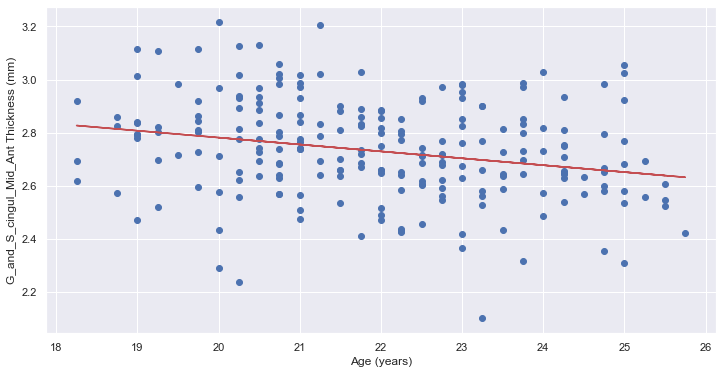

In [286]:
# lets visualise this regression line
x = hemi_df['age']
y = hemi_df['G_and_S_cingul_Mid_Ant']
ypred = results.params[0] + hemi_df['age']*results.params[2]

plt.figure(figsize=(12, 6))
plt.scatter(x, y,)
plt.plot(x, ypred, c='r')
plt.ylabel('G_and_S_cingul_Mid_Ant Thickness (mm)')
plt.xlabel('Age (years)')

### Challenge

Try performing the same regression above but in using the overall mean thickness. Is there a significant relationship with age?


Solution

In [287]:
results_m2 = smf.ols(f"{'MeanThickness'} ~ {predictor} + {covariates}", data=hemi_df).fit()
results_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MeanThickness   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     11.72
Date:                Tue, 16 Aug 2022   Prob (F-statistic):           3.76e-07
Time:                        12:25:19   Log-Likelihood:                 258.55
No. Observations:                 224   AIC:                            -509.1
Df Residuals:                     220   BIC:                            -495.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.8176      0.076     36.928      0.000       2.667       2.968
C(sex)[T.M]     0.0055      0.014      0.398      0.691      -0.022       0.032
age            -0.0157      0.003     -5.420      0.000      -0.021      -0.010
eTIV         5.099e-08   3.16e-08      1.613      0.108   -1.13e-08    1.13e-07
==============================================================================
Omnibus:                        0.177   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.915   Jarque-Bera (JB):                0.142
Skew:                           0.061   Prob(JB):                        0.932
Kurtosis:                       2.982   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### EXTRA Challenge

Other factors we haven't included may also influence cortical thickness such as whether someone is left or right handed (coded as `handedness` in the demographics file).

Can you rerun the analysis of the `G_and_S_cingul_Mid_Ant` above including handedness as a covariate?

Does `age` still significantly predict cortical thickness in this region?

Solution

In [288]:
# only keep demographic values of interest
demo_cols = ["participant_id", "age", "sex", "handedness"]

# merge demographic and cortical thickness dataframes together
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')

# left hemisphere only again
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi'] == hemi]

# set up model
response = 'G_and_S_cingul_Mid_Ant'
predictor = 'age'
covariates = 'eTIV + C(sex) + C(handedness)' # [age, sex, BMI, education_category]

# Fit regression model
results_m3 = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()

# Inspect the results
results_m3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     G_and_S_cingul_Mid_Ant   R-squared:                       0.079
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     3.743
Date:                    Tue, 16 Aug 2022   Prob (F-statistic):            0.00285
Time:                            12:25:19   Log-Likelihood:                 67.313
No. Observations:                     224   AIC:                            -122.6
Df Residuals:                         218   BIC:                            -102.2
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.2933      0.262     12.567      0.000       2.777       3.810
C(sex)[T.M]                0.0060      0.033      0.184      0.854      -0.058       0.070
C(handedness)[T.left]     -0.0463      0.188     -0.247      0.805      -0.416       0.324
C(handedness)[T.right]     0.0365      0.184      0.198      0.843      -0.327       0.400
age                       -0.0267      0.007     -3.906      0.000      -0.040      -0.013
eTIV                    1.267e-09   7.52e-08      0.017      0.987   -1.47e-07     1.5e-07
==============================================================================
Omnibus:                        2.986   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.631
Skew:                          -0.205   Prob(JB):                        0.268
Kurtosis:                       3.338   Cond. No.                     3.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Implementing it on all ROIs

In neuroimaging, we often perform statistical analysis on many regions. This involves running regressions like the above many times.

If you're interested in how to do this, look at the corresponding episiode on the [sMRI Software Carpentry](https://carpentries-incubator.github.io/SDC-BIDS-sMRI/06-Statistical_Analysis/index.html) course for details on how to do this. 

## Reproducibility